## Práctica  Sympy 2

Generar un modelo de simulación para el proceso de vacunación del Covid. Para ello se debe investigar algun recinto de vacunación con el objetivo de generar métricas en base a los siguientes datos:

- Personal de vacunación
- Número de personas llamadas
- Otro parámetros

El proceso de vacunación es el siguiente:

- Ingresa a la fila a que le toque su turno.
- Tenemos un proceso de control en donde se toma los signos vitales y se valida que esté dentro del padrón (2-5 minutos).
- Como ejemplificación menos del 5% no es vacunada ya que presenta signos de alerta.
- Se procede al traslado a la silla de vacunación y se inyecta la dosis de la vacuna (5-10 minutos).
- Finalmente son llevados a la salida (1-3 minutos).

Finalmente generar las siguientes métricas/gráficas:

- Tiempo de espera promedio para cada persona.
- Tiempo promedio total que requiere un paciente para ser vacunado.
- Cuántos pacientes se atendieron.
- Cuántos pacientes se quedaron sin atender.

In [98]:
import simpy
import random
import matplotlib.pyplot as pp

# Personal de vacunación
PERSONAL = 10
# Intervalo de tiempo en el que llegan las personas (minutos)
INTERVALO_LLEGADA = 20
# Intervalo de control de una persona 
INTERVALO_CONTROL = 3
# Intervalo vacunación (minutos)
INTERVALO_VACUNACION = 8
# Intervalo de tiempo en el que una persona sale del centro de vacunación
INTERVALO_SALIDA = 2
# Tiempo de simulación
TIEMPO_SIMULACION = 100
# Cantidad de vacunados
CANTIDAD_VACUNADOS = 0
# Cantidad de personas que llegaron
CANTIDAD_PERSONAS = 0
# Tiempo Vacunación
TIEMPOVACUNACION = 0
# Tiempo Espera
TIEMPOESPERA = 0
# Tiempo de vacunación de cada persona
TIEMPOVACUNACIONDICT = {}
# Tiempo de espera de cada persona
TIEMPOESPERADICT = {}

class Vacunacion(object):

    def __init__(self, environment, cantPersonal, tiempoVacunacion, tiempoControl, tiempoSalida):
        self.env = environment
        #Creamos el recurso del personal o puestos de vacunación
        self.personal = simpy.Resource(environment, cantPersonal)
        self.tiempoControl = tiempoControl
        self.tiempoVacunacion = tiempoVacunacion
        self.tiempoSalida = tiempoSalida

    def controlPersona(self):
        yield self.env.timeout(random.randint(self.tiempoControl-1, self.tiempoControl+2))
        
    def vacunar_persona(self, persona):
        yield self.env.timeout(random.randint(self.tiempoVacunacion-3, self.tiempoVacunacion+2))
        
    def salidaPersona(self):
        yield self.env.timeout(random.randint(self.tiempoSalida-1, self.tiempoSalida+1))

        
def conteoVacunados():
    global CANTIDAD_VACUNADOS
    CANTIDAD_VACUNADOS +=1

def conteoPersonas():
    global CANTIDAD_PERSONAS
    CANTIDAD_PERSONAS +=1
    
def tiempoEspera(persona, tiempoEspera):
    global TIEMPOESPERA
    global TIEMPOESPERADICT
    # Agregamos al diccionario el tiempo de espera por persona
    TIEMPOESPERADICT[persona.split('-')[1]] = tiempoEspera
    # Se obtiene el tiempo total de espera de todas las personas
    TIEMPOESPERA += tiempoEspera
    
def tiempoVacunacion(persona, tiempoPersona):
    global TIEMPOVACUNACION 
    global TIEMPOVACUNACIONDICT
    # Agregamos al diccionario el tiempo de vacunación por persona
    TIEMPOVACUNACIONDICT[persona.split('-')[1]] = tiempoPersona
    # Se obtiene el tiempo total de vacunación de todas las personas
    TIEMPOVACUNACION += tiempoPersona
    

def llegada_persona(env, nombre, vacunacion):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega una persona con el nombre pasado como parametro
    print(' → Llega persona: %s a la hora %.2f.' % (nombre, env.now))
    
    # Inicio del proceso
    inicioEspera = env.now
    
    # La persona tarda 1 minuto hasta llegar al control
    yield env.timeout(1)
    print('La persona: %s entra al control a la hora %.2f.' % (nombre, env.now))
    
    # Indicamos que la persona entra en el proceso de control
    yield env.process(vacunacion.controlPersona())
    print('La persona: %s sale control a la hora %.2f.' % (nombre, env.now))
    
    # Despues del control se cumple con que solo el 5% de las personas 
    # no cumplen con las condiciones para ser vacunadas
    rnd = random.randint(1,100)
    if rnd <= 5:
        print('La persona [%s] no cumple con los requerimientos'%(nombre))
    else:
        # Especificamos que vamos a usar un recurso (Resource) que representa
        # un doctor
        with vacunacion.personal.request() as doctor:
            # Se ocupa un doctor para la vacunación de una persona.
            yield doctor
            
            #Indicamos que la persona entra en el proceso de vacunación
            print('Se traslada %s a la silla de vacunación a la hora %.2f.' % (nombre,env.now))
    
            # Inicia el tiempo de la vacunación
            inicio = env.now
    
            # Procesamos la aplicación de la vacuna
            yield env.process(vacunacion.vacunar_persona(nombre))
            
            # Se registra otra persona vacunada
            conteoVacunados()
            
            # Obtener el tiempo total de la vacunación de una persona
            tiempoVacunacion(nombre, env.now-inicio)
            
            # Una vez que termina la llamada con 'yield', se indica que se ha vacunado la persona
            print('La [%s] fue vacunada a las %.2f.' % (nombre, env.now)) 
                      
            # Obtener el tiempo total de espera de una persona
            tiempoEspera(nombre, env.now-inicioEspera)
            
            # La persona despues de ser vacuna sale del centro de vacunación
            yield env.process(vacunacion.salidaPersona())
            print('La persona [%s] sale del centro a las %.2f.' % (nombre, env.now)) 
            
            
        
def ejecutar_simulacion(env, cantPersonal, tiempoVacunacion, tiempoControl, tiempoSalida):
    vacunacion=Vacunacion(env, cantPersonal, tiempoVacunacion, tiempoControl, tiempoSalida)
    
    # Creamos 5 persona que llegan
    for i in range(5):
        conteoPersonas()
        env.process(llegada_persona(env, 'Persona-%d'%(i+1), vacunacion))
        
        
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(5)
        i+=1
        conteoPersonas()
        env.process(llegada_persona(env,'Persona-%d'%(i+1), vacunacion))  
    

print('Vacunación UPS')
# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, PERSONAL, INTERVALO_VACUNACION,INTERVALO_CONTROL, INTERVALO_SALIDA))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

Vacunación UPS
 → Llega persona: Persona-1 a la hora 0.00.
 → Llega persona: Persona-2 a la hora 0.00.
 → Llega persona: Persona-3 a la hora 0.00.
 → Llega persona: Persona-4 a la hora 0.00.
 → Llega persona: Persona-5 a la hora 0.00.
La persona: Persona-1 entra al control a la hora 1.00.
La persona: Persona-2 entra al control a la hora 1.00.
La persona: Persona-3 entra al control a la hora 1.00.
La persona: Persona-4 entra al control a la hora 1.00.
La persona: Persona-5 entra al control a la hora 1.00.
La persona: Persona-4 sale control a la hora 3.00.
La persona: Persona-5 sale control a la hora 3.00.
Se traslada Persona-4 a la silla de vacunación a la hora 3.00.
Se traslada Persona-5 a la silla de vacunación a la hora 3.00.
 → Llega persona: Persona-6 a la hora 5.00.
La persona: Persona-1 sale control a la hora 5.00.
La persona: Persona-2 sale control a la hora 5.00.
Se traslada Persona-1 a la silla de vacunación a la hora 5.00.
Se traslada Persona-2 a la silla de vacunación a la h

#### Métricas sobre:
- La cantidad de personas que asistieron.
- La cantidad de vacunados y no vacunados.
- El tiempo total solamente de la vacunación.
- El tiempo promedio de vacunación.
- El tiempo promedio de espera de las personas.

In [99]:
print('Total de Personas:', CANTIDAD_PERSONAS, '\n')
print('Total Vacunados:', CANTIDAD_VACUNADOS, '\n')
print('Total No Vacunados:', CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS, '\n')
print('Tiempo de vacunación promedio: ', round(TIEMPOVACUNACION/CANTIDAD_VACUNADOS, 2), '\n')
print('Tiempo de espera promedio: ', round(TIEMPOESPERA/CANTIDAD_VACUNADOS, 2), '\n')
print('Tiempo total de vacunación: ', TIEMPOVACUNACION, '\n')

Total de Personas: 24 

Total Vacunados: 21 

Total No Vacunados: 3 

Tiempo de vacunación promedio:  6.76 

Tiempo de espera promedio:  11.0 

Tiempo total de vacunación:  142 



### Gráfico: Tiempo de vacunación por persona

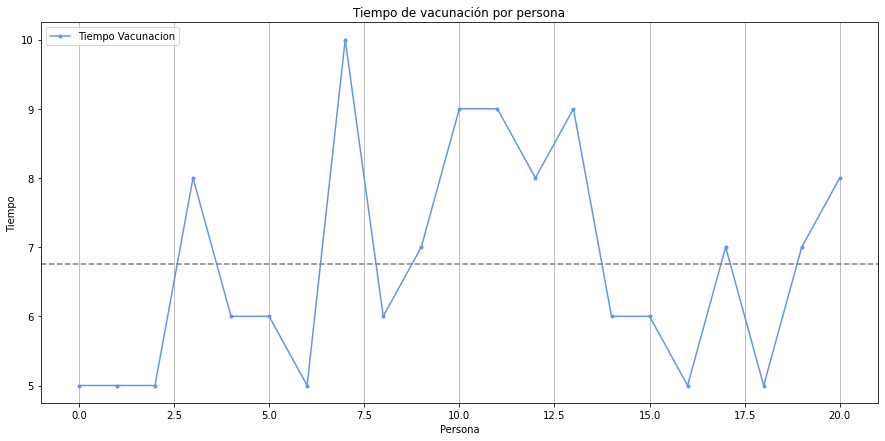

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

plt.title("Tiempo de vacunación por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOVACUNACIONDICT.keys())
plt.plot(range(len(TIEMPOVACUNACIONDICT)), list(TIEMPOVACUNACIONDICT.values()), '.-', label='Tiempo Vacunacion', color='cornflowerblue')

plt.axhline(y=TIEMPOVACUNACION/CANTIDAD_VACUNADOS, color='gray', linestyle='--')

plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

### Gráfico del tiempo de espera total por persona

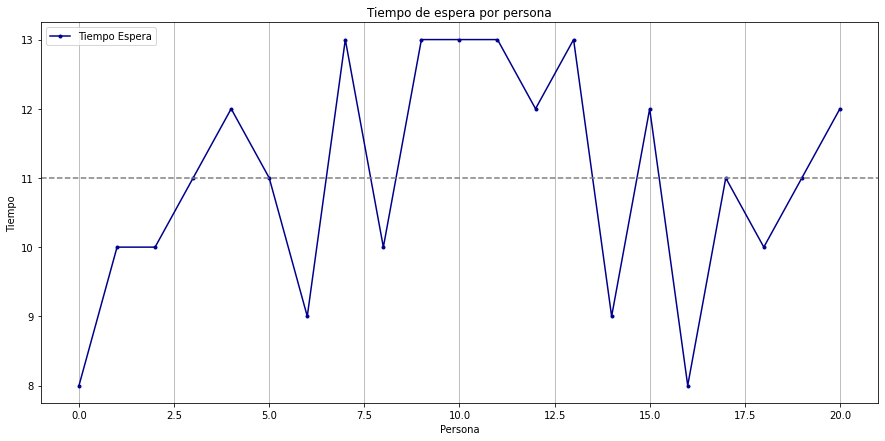

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

plt.title("Tiempo de espera por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOESPERADICT.keys())
plt.plot(range(len(TIEMPOESPERADICT)), list(TIEMPOESPERADICT.values()), '.-', label='Tiempo Espera', color='darkblue')

plt.axhline(y=TIEMPOESPERA/CANTIDAD_VACUNADOS, color='gray', linestyle='--')

plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

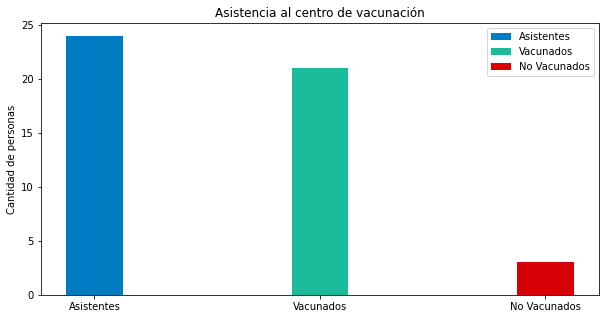

In [103]:
import matplotlib.pyplot as plt

x = [1,2,3]

tags = ['Asistentes','Vacunados', 'No Vacunados']

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x[0], CANTIDAD_PERSONAS, 0.25, label='Asistentes', color="#007CC2")
rects2 = ax.bar(x[1], CANTIDAD_VACUNADOS, 0.25, label='Vacunados', color='#1ABC9C')
rects3= ax.bar(x[2], CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS, 0.25, label='No Vacunados', color="#D70006")

ax.set_ylabel('Cantidad de personas')
ax.set_title('Asistencia al centro de vacunación')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")

plt.show()